--- Step 1: Loading and Preparing Data ---
Error: 'Haldirams_reclassified_entire_dataset(1).csv' not found.
Data prepared. Total samples: 1186
Underperforming products (class 1): 312 (26.31%)

--- Step 2: Splitting Data into Training and Test Sets ---
Training set size: 948 rows
Test set size: 238 rows

--- Step 3: Defining Preprocessing and Model Pipelines ---
Pipeline created for: Logistic Regression
Pipeline created for: Decision Tree
Pipeline created for: Random Forest

--- Step 4: Training and Evaluating Models ---

Training Logistic Regression...

Training Decision Tree...

Training Random Forest...

--- Classification Report for Logistic Regression ---
                     precision    recall  f1-score   support

Not Underperforming       0.97      0.89      0.93       175
    Underperforming       0.75      0.92      0.83        63

           accuracy                           0.90       238
          macro avg       0.86      0.91      0.88       238
       weighted avg      

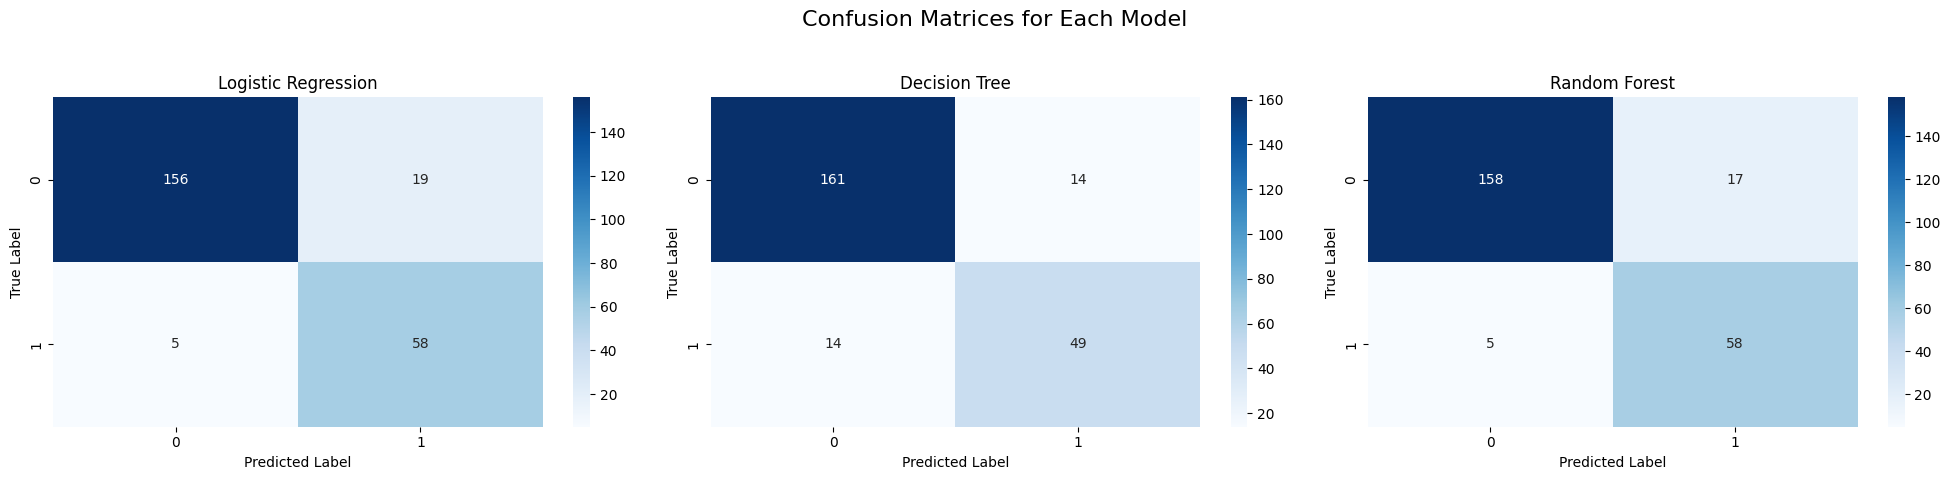


--- Model Performance Summary ---
                     Overall Accuracy  Precision (Underperforming)  \
Model                                                                
Logistic Regression          0.899160                     0.753247   
Decision Tree                0.882353                     0.777778   
Random Forest                0.907563                     0.773333   

                     Recall (Underperforming)  F1-Score (Underperforming)  
Model                                                                      
Logistic Regression                  0.920635                    0.828571  
Decision Tree                        0.777778                    0.777778  
Random Forest                        0.920635                    0.840580  

--- Step 6: Interpreting Models with SHAP ---

--- Generating SHAP Summary for Logistic Regression ---


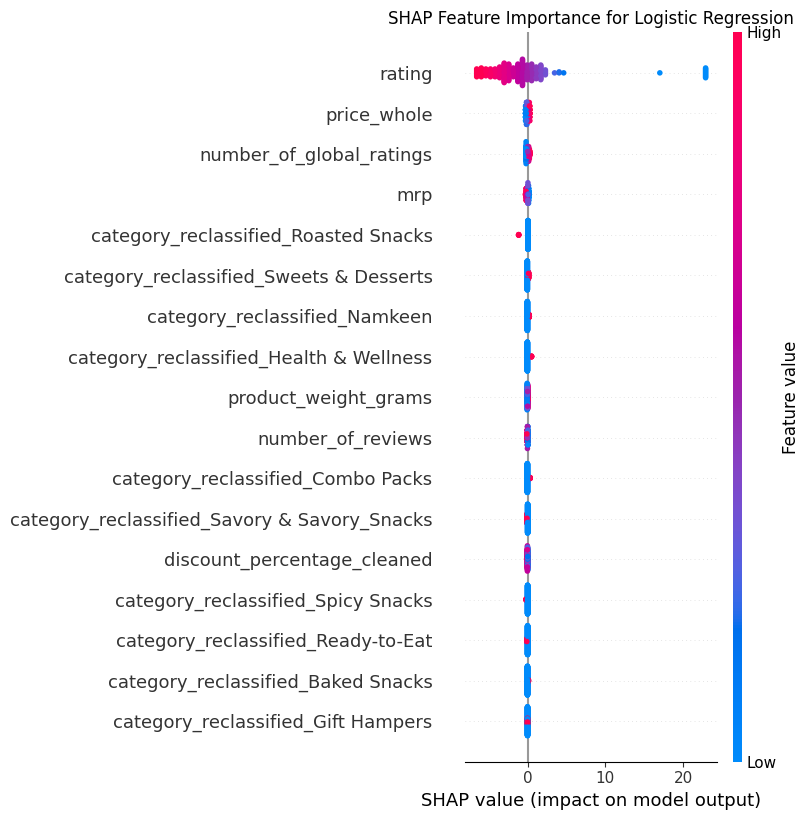


--- Generating SHAP Summary for Decision Tree ---


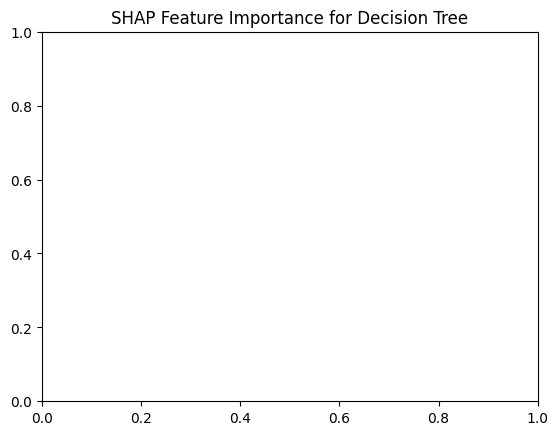

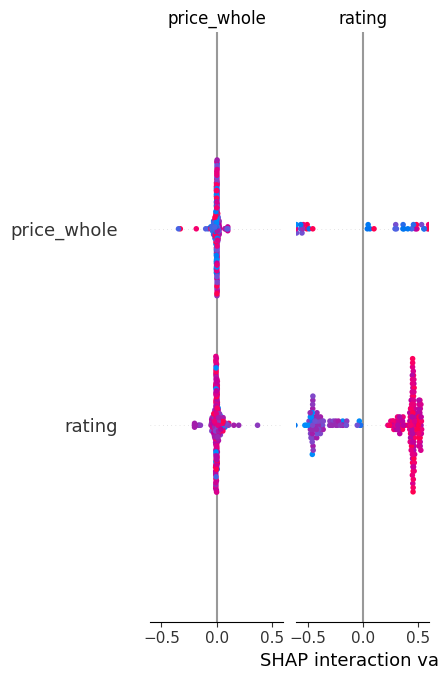


--- Generating SHAP Summary for Random Forest ---


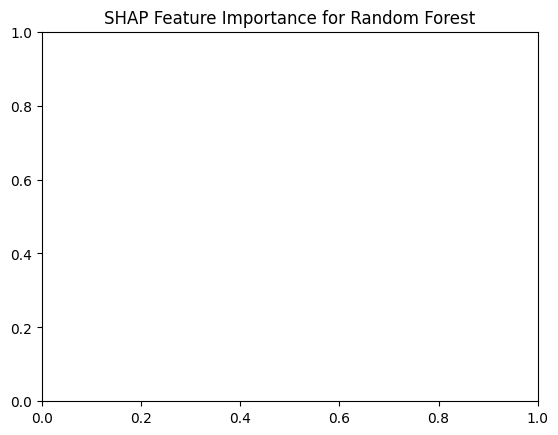

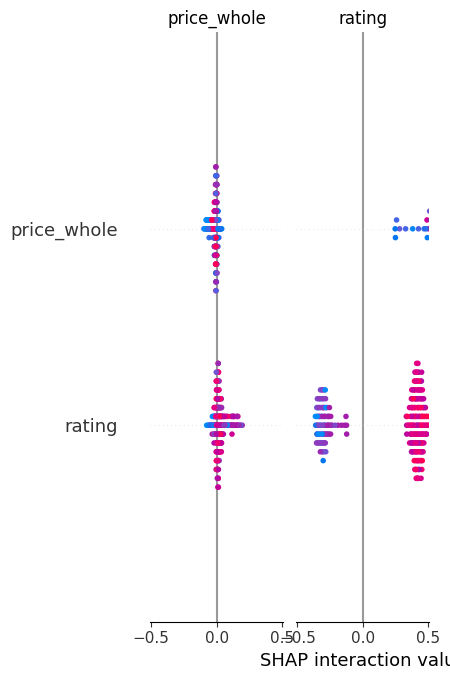

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap # <-- Import SHAP

# --- 1. Problem Framing & Constants ---

# Define the target variable and the business rule for its creation
TARGET_COL = 'is_underperforming'
RATING_THRESHOLD = 4.0
SALES_THRESHOLD = 50

# Define feature types for the preprocessor
NUMERIC_COLS = [
    'rating', 'price_whole', 'mrp', 'number_of_global_ratings',
    'number_of_reviews', 'discount_percentage_cleaned', 'product_weight_grams'
]
CATEGORICAL_COLS = ['category_reclassified']


# --- 2. Data Loading & Feature Engineering ---
print("--- Step 1: Loading and Preparing Data ---")
try:
    # Make sure to use the correct file name you have uploaded
    df = pd.read_csv('Haldirams_reclassified_entire_dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'Haldirams_reclassified_entire_dataset.csv' not found.")
    print("Please ensure the CSV file is in the correct directory.")
    exit()

# Engineer the target variable based on the defined rule
df[TARGET_COL] = ((df['rating'] < RATING_THRESHOLD) & (df['sales_numeric'] < SALES_THRESHOLD)).astype(int)

# Clean the data by dropping rows with missing values in our selected columns
features_to_check = NUMERIC_COLS + CATEGORICAL_COLS + ['sales_numeric']
df_clean = df.dropna(subset=features_to_check)

# Define the final features (X) and target (y)
X = df_clean[NUMERIC_COLS + CATEGORICAL_COLS]
y = df_clean[TARGET_COL]

print(f"Data prepared. Total samples: {len(df_clean)}")
print(f"Underperforming products (class 1): {y.sum()} ({y.mean()*100:.2f}%)")


# --- 3. Data Splitting ---
print("\n--- Step 2: Splitting Data into Training and Test Sets ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {len(X_train)} rows")
print(f"Test set size: {len(X_test)} rows")


# --- 4. Preprocessing & Modeling Pipelines ---
print("\n--- Step 3: Defining Preprocessing and Model Pipelines ---")
# Create a preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERIC_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_COLS)
    ],
    remainder='passthrough'
)

# Define the three models to be trained
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced')
}

# Create a pipeline for each model
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    print(f"Pipeline created for: {name}")


# --- 5. Model Training and Evaluation ---
print("\n--- Step 4: Training and Evaluating Models ---")
results = {}
for name, pipe in pipelines.items():
    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Store results
    results[name] = {
        'report': classification_report(y_test, y_pred, target_names=['Not Underperforming', 'Underperforming']),
        'cm': confusion_matrix(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred)
    }

# Display classification reports
for name, res in results.items():
    print(f"\n--- Classification Report for {name} ---")
    print(res['report'])


# --- 6. Comparison and Visualization ---
print("\n--- Step 5: Visualizing and Comparing Model Performance ---")

# Plotting Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Confusion Matrices for Each Model', fontsize=16)

for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Create a summary DataFrame for comparison
summary_data = []
for name, res in results.items():
    report_dict = classification_report(y_test, pipelines[name].predict(X_test), output_dict=True)
    # Correctly reference the class '1' for underperforming
    underperforming_metrics = report_dict['1']
    summary_data.append({
        'Model': name,
        'Overall Accuracy': res['accuracy'],
        'Precision (Underperforming)': underperforming_metrics['precision'],
        'Recall (Underperforming)': underperforming_metrics['recall'],
        'F1-Score (Underperforming)': underperforming_metrics['f1-score']
    })

summary_df = pd.DataFrame(summary_data).set_index('Model')
print("\n--- Model Performance Summary ---")
print(summary_df)


# --- 7. Model Interpretation with SHAP ---
print("\n--- Step 6: Interpreting Models with SHAP ---")

# First, get the processed data and feature names from the pipeline
# We can use any fitted pipeline since the preprocessor step is the same
fitted_preprocessor = pipelines['Random Forest'].named_steps['preprocessor']
X_test_processed = fitted_preprocessor.transform(X_test)

# Get the correct feature names after one-hot encoding
ohe_feature_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(CATEGORICAL_COLS)
feature_names = NUMERIC_COLS + list(ohe_feature_names)

# Convert the processed test data (which might be sparse) to a dense DataFrame
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)
X_train_processed_df = pd.DataFrame(fitted_preprocessor.transform(X_train).toarray(), columns=feature_names)


for name, pipe in pipelines.items():
    print(f"\n--- Generating SHAP Summary for {name} ---")

    # Get just the classifier part of the pipeline
    classifier = pipe.named_steps['classifier']

    # Choose the correct explainer based on model type
    if isinstance(classifier, LogisticRegression):
        # Use LinearExplainer for logistic regression
        explainer = shap.LinearExplainer(classifier, X_train_processed_df)
        shap_values = explainer.shap_values(X_test_processed_df)

    else: # For DecisionTree and RandomForest
        # Use TreeExplainer for tree-based models
        explainer = shap.TreeExplainer(classifier)
        # For binary classification, shap_values is a list of two arrays (one for each class)
        # We're interested in the values for the "Underperforming" class (class 1)
        shap_values = explainer.shap_values(X_test_processed_df)

    # Create the SHAP summary plot
    plt.title(f'SHAP Feature Importance for {name}')
    shap.summary_plot(shap_values, X_test_processed_df, show=False)
    plt.show()

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=27200aa6062cf0921ca7d054ecb3710fb484fa0eb0291d8624fc2ee3313adbc7
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
import lime
import lime.lime_tabular

# --- 1. Problem Framing & Constants ---
TARGET_COL = 'is_underperforming'
RATING_THRESHOLD = 4.0
SALES_THRESHOLD = 50
NUMERIC_COLS = [
    'rating', 'price_whole', 'mrp', 'number_of_global_ratings',
    'number_of_reviews', 'discount_percentage_cleaned', 'product_weight_grams'
]
CATEGORICAL_COLS = ['category_reclassified']

# --- 2. Data Loading & Feature Engineering ---
print("--- Step 1: Loading and Preparing Data ---")
try:
    df = pd.read_csv('Haldirams_reclassified_entire_dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'Haldirams_reclassified_entire_dataset.csv' not found.")
    exit()

df[TARGET_COL] = ((df['rating'] < RATING_THRESHOLD) & (df['sales_numeric'] < SALES_THRESHOLD)).astype(int)
features_to_check = NUMERIC_COLS + CATEGORICAL_COLS + ['sales_numeric']
df_clean = df.dropna(subset=features_to_check)
X = df_clean[NUMERIC_COLS + CATEGORICAL_COLS]
y = df_clean[TARGET_COL]
print(f"Data prepared. Total samples: {len(df_clean)}")
print(f"Underperforming products (class 1): {y.sum()} ({y.mean()*100:.2f}%)")

# --- 3. Data Splitting ---
print("\n--- Step 2: Splitting Data into Training and Test Sets ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {len(X_train)} rows")
print(f"Test set size: {len(X_test)} rows")

# --- 4. Preprocessing & Modeling Pipelines ---
print("\n--- Step 3: Defining Preprocessing and Model Pipelines ---")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERIC_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_COLS)
    ],
    remainder='passthrough'
)
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced')
}
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    print(f"Pipeline created for: {name}")

# --- 5. Model Training and Evaluation ---
print("\n--- Step 4: Training and Evaluating Models ---")
for name, pipe in pipelines.items():
    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)

# (Previous SHAP and other analysis code would go here)
# ...

# --- 8. Model Interpretation with LIME ---
print("\n--- Step 7: Interpreting a Single Prediction with LIME ---")

# Preprocess the training data for LIME
# Fit the preprocessor on X_train before transforming
fitted_preprocessor = pipelines['Random Forest'].named_steps['preprocessor'] # Use any fitted pipeline to get the preprocessor
X_train_processed = fitted_preprocessor.transform(X_train)
if hasattr(X_train_processed, 'toarray'):
    X_train_processed = X_train_processed.toarray()

# Get the correct feature names after one-hot encoding
ohe_feature_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(CATEGORICAL_COLS)
feature_names_processed = NUMERIC_COLS + list(ohe_feature_names)


# 1. Create a LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_processed,
    feature_names=feature_names_processed,
    class_names=['Not Underperforming', 'Underperforming'],
    # No need to specify categorical_features here as the data is already one-hot encoded
    mode='classification'
)

# 2. Choose an instance from the test set to explain
instance_to_explain = X_test.iloc[[4]]
instance_idx = 4
print(f"Explaining prediction for instance #{instance_idx} in the test set.")
print("Original instance details:\n", instance_to_explain)

# Preprocess the instance to explain before passing it to LIME
instance_to_explain_processed = fitted_preprocessor.transform(instance_to_explain)
if hasattr(instance_to_explain_processed, 'toarray'):
     instance_to_explain_processed = instance_to_explain_processed.toarray()
instance_to_explain_processed = instance_to_explain_processed[0] # LIME expects a single instance as a 1D array


# 3. Generate and save an explanation for each model
for name, pipe in pipelines.items():
    print(f"\n--- Generating LIME explanation for {name} ---")

    # Use the original instance for the pipeline's predict_proba to get the model's prediction
    prediction_probas = pipe.predict_proba(instance_to_explain)
    original_prediction = y_test.iloc[instance_idx]

    print(f"Model Prediction Probability ('Underperforming'): {prediction_probas[0][1]:.4f}")
    print(f"Actual Label: {'Underperforming' if original_prediction == 1 else 'Not Underperforming'}")

    # Define a wrapper function that takes the preprocessed data and passes it to the classifier
    def predict_proba_wrapper(data):
        # LIME passes a numpy array of preprocessed data, pass it directly to the classifier step
        return pipe.named_steps['classifier'].predict_proba(data)

    explanation = explainer.explain_instance(
        data_row=instance_to_explain_processed, # Pass the processed instance as a 1D array
        predict_fn=predict_proba_wrapper, # Use the wrapper function
        num_features=10
    )

    file_name = f'lime_explanation_{name.replace(" ", "_")}.html'
    explanation.save_to_file(file_name)
    print(f"Explanation saved to: {file_name}")

--- Step 1: Loading and Preparing Data ---
Dataset loaded successfully!
Data prepared. Total samples: 1186
Underperforming products (class 1): 312 (26.31%)

--- Step 2: Splitting Data into Training and Test Sets ---
Training set size: 948 rows
Test set size: 238 rows

--- Step 3: Defining Preprocessing and Model Pipelines ---
Pipeline created for: Logistic Regression
Pipeline created for: Decision Tree
Pipeline created for: Random Forest

--- Step 4: Training and Evaluating Models ---

Training Logistic Regression...

Training Decision Tree...

Training Random Forest...

--- Step 7: Interpreting a Single Prediction with LIME ---
Explaining prediction for instance #4 in the test set.
Original instance details:
      rating  price_whole  mrp  number_of_global_ratings  number_of_reviews  \
710     4.3          157  258                     41114               5721   

     discount_percentage_cleaned  product_weight_grams category_reclassified  
710                           10            

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import shap
import lime
import lime.lime_tabular
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_difference

# --- 1. Problem Framing & Constants ---
TARGET_COL = 'is_underperforming'
RATING_THRESHOLD = 4.0
SALES_THRESHOLD = 50
NUMERIC_COLS = [
    'rating', 'price_whole', 'mrp', 'number_of_global_ratings',
    'number_of_reviews', 'discount_percentage_cleaned', 'product_weight_grams'
]
CATEGORICAL_COLS = ['category_reclassified']

# --- 2. Data Loading & Feature Engineering ---
print("--- Step 1: Loading and Preparing Data ---")
try:
    df = pd.read_csv('Haldirams_reclassified_entire_dataset.csv')
    print("Dataset loaded successfully!")

    df[TARGET_COL] = ((df['rating'] < RATING_THRESHOLD) & (df['sales_numeric'] < SALES_THRESHOLD)).astype(int)
    features_to_check = NUMERIC_COLS + CATEGORICAL_COLS + ['sales_numeric']
    df_clean = df.dropna(subset=features_to_check)
    X = df_clean[NUMERIC_COLS + CATEGORICAL_COLS]
    y = df_clean[TARGET_COL]
    print(f"Data prepared. Total samples: {len(df_clean)}")
    print(f"Underperforming products (class 1): {y.sum()} ({y.mean()*100:.2f}%)")

    # --- 3. Data Splitting ---
    print("\n--- Step 2: Splitting Data into Training and Test Sets ---")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Training set size: {len(X_train)} rows")
    print(f"Test set size: {len(X_test)} rows")

    # --- 4. Preprocessing & Modeling Pipelines ---
    print("\n--- Step 3: Defining Preprocessing and Model Pipelines ---")
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), NUMERIC_COLS),
            ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_COLS)
        ],
        remainder='passthrough'
    )
    models = {
        "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
        "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced')
    }
    pipelines = {}
    for name, model in models.items():
        pipelines[name] = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        print(f"Pipeline created for: {name}")

    # --- 5. Model Training ---
    print("\n--- Step 4: Training Models ---")
    for name, pipe in pipelines.items():
        print(f"Training {name}...")
        pipe.fit(X_train, y_train)

    # (SHAP and LIME code would go here... omitted for brevity)

    # --- 9. Fairness Audit with Fairlearn ---
    print("\n--- Step 8: Auditing Models for Fairness ---")

    # Define the sensitive feature we want to audit
    sensitive_feature = X_test['category_reclassified']

    # Define the metrics we want to check across groups
    fairness_metrics = {
        'accuracy': accuracy_score,
        'f1_score': f1_score,
        'selection_rate': selection_rate # The rate at which the model predicts 'underperforming'
    }

    # Store MetricFrame results for later visualization
    metric_frames = {}

    # Loop through each trained model to evaluate its fairness
    for name, pipe in pipelines.items():
        print(f"\n--- Fairness Audit for {name} ---")

        y_pred = pipe.predict(X_test)

        # Create and store the MetricFrame
        metric_frames[name] = MetricFrame(metrics=fairness_metrics,
                                          y_true=y_test,
                                          y_pred=y_pred,
                                          sensitive_features=sensitive_feature)

        print("Metrics by Product Category:")
        print(metric_frames[name].by_group)

        print("\nMetric Differences (Max - Min):")
        print(metric_frames[name].difference())

        eod = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_feature)
        print(f"\nEqualized Odds Difference: {eod:.4f}")

    # --- Visualize Fairness Metrics for the Best Model (Random Forest) ---
    print("\n--- Visualizing Fairness Metrics for Random Forest ---")

    rf_metrics_by_group = metric_frames['Random Forest'].by_group

    fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=False)
    fig.suptitle('Fairness Metrics for Random Forest by Product Category', fontsize=16)

    # Plot Accuracy by Group
    rf_metrics_by_group['accuracy'].plot(kind='bar', ax=ax[0], color='skyblue', rot=45)
    ax[0].set_title('Accuracy Score by Category')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('')

    # Plot Selection Rate by Group
    rf_metrics_by_group['selection_rate'].plot(kind='bar', ax=ax[1], color='salmon', rot=45)
    ax[1].set_title('Selection Rate ("Underperforming" Flag) by Category')
    ax[1].set_ylabel('Selection Rate')
    ax[1].set_xlabel('')

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


except FileNotFoundError:
    print("Error: 'Haldirams_reclassified_entire_dataset.csv' not found.")
    # Exit or handle the error appropriately
    # For demonstration, we'll just stop execution here
    exit() # Or sys.exit(1) if sys is imported
except NameError as e:
    print(f"A NameError occurred: {e}")
    print("This likely means a variable was accessed before it was defined.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Step 1: Loading and Preparing Data ---
Error: 'Haldirams_reclassified_entire_dataset.csv' not found.


In [ ]:
pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.1 MB/s eta 0:00:00


In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=788366ec4e5d489e2089f27edbe044e9d23067c4770d5395ee8ad304f7dd8382
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
# --- 0. Import Necessary Libraries ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_difference
import matplotlib.pyplot as plt

# --- 1. Problem Framing & Constants ---
TARGET_COL = 'is_underperforming'
RATING_THRESHOLD = 4.0
SALES_THRESHOLD = 50
NUMERIC_COLS = [
    'rating', 'price_whole', 'mrp', 'number_of_global_ratings',
    'number_of_reviews', 'discount_percentage_cleaned', 'product_weight_grams'
]
CATEGORICAL_COLS = ['category_reclassified']

# --- 2. Data Loading & Feature Engineering ---
print("--- Step 1: Loading and Preparing Data ---")
try:
    # This line uses the correct filename you uploaded.
    df = pd.read_csv('/content/drive/MyDrive/Haldirams_reclassified_entire_dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("CRITICAL ERROR: 'Haldirams_reclassified_entire_dataset.csv' not found.")
    print("Please ensure the file is uploaded to the correct directory.")
    exit() # Stop execution if the file isn't found

# Engineer the target variable based on the defined rule
df[TARGET_COL] = ((df['rating'] < RATING_THRESHOLD) & (df['sales_numeric'] < SALES_THRESHOLD)).astype(int)

# Clean the data by dropping rows with missing values in our selected columns
features_to_check = NUMERIC_COLS + CATEGORICAL_COLS + ['sales_numeric']
df_clean = df.dropna(subset=features_to_check)

# Define the final features (X) and target (y)
X = df_clean[NUMERIC_COLS + CATEGORICAL_COLS]
y = df_clean[TARGET_COL]

print(f"Data prepared. Total samples: {len(df_clean)}")

# --- 3. Data Splitting ---
print("\n--- Step 2: Splitting Data into Training and Test Sets ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {len(X_train)} rows")
print(f"Test set size: {len(X_test)} rows")

# --- 4. Preprocessing & Modeling Pipelines ---
print("\n--- Step 3: Defining Preprocessing and Model Pipelines ---")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERIC_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_COLS)
    ]
)
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced')
}
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    print(f"Pipeline created for: {name}")

# --- 5. Model Training ---
print("\n--- Step 4: Training Models ---")
for name, pipe in pipelines.items():
    print(f"Training {name}...")
    pipe.fit(X_train, y_train)

# --- 6. Fairness Audit with Fairlearn ---
print("\n--- Step 5: Auditing Models for Fairness ---")

# Define the sensitive feature we want to audit (product category)
sensitive_feature = X_test['category_reclassified']

# Define the metrics we care about for fairness
fairness_metrics = {
    'accuracy': accuracy_score,
    'f1_score': f1_score,
    'selection_rate': selection_rate # The rate at which the model predicts 'underperforming'
}

# Store MetricFrame results for later visualization
metric_frames = {}

# Loop through each trained model to evaluate its fairness
for name, pipe in pipelines.items():
    print(f"\n--- Fairness Audit for {name} ---")

    y_pred = pipe.predict(X_test)

    # Use MetricFrame to compute metrics, grouped by the sensitive feature
    metric_frames[name] = MetricFrame(metrics=fairness_metrics,
                                      y_true=y_test,
                                      y_pred=y_pred,
                                      sensitive_features=sensitive_feature)

    print("Metrics by Product Category:")
    print(metric_frames[name].by_group)

    print("\nMetric Differences (between the best and worst-off groups):")
    print(metric_frames[name].difference())

    # Calculate Equalized Odds Difference (checks for fairness in error rates)
    eod = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_feature)
    print(f"\nEqualized Odds Difference: {eod:.4f}")

# --- 7. Visualize Fairness Metrics for the Best Model (Random Forest) ---
print("\n--- Step 6: Visualizing Fairness Metrics for Random Forest ---")

# Get the fairness results for the Random Forest model
rf_metrics_by_group = metric_frames['Random Forest'].by_group

# Create a plot to visualize the metrics
fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=False)
fig.suptitle('Fairness Metrics for Random Forest by Product Category', fontsize=16)

# Plot Accuracy by Group
rf_metrics_by_group['accuracy'].plot(kind='bar', ax=ax[0], color='skyblue', rot=45)
ax[0].set_title('Accuracy Score by Category')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('')

# Plot Selection Rate by Group
rf_metrics_by_group['selection_rate'].plot(kind='bar', ax=ax[1], color='salmon', rot=45)
ax[1].set_title('Selection Rate ("Underperforming" Flag) by Category')
ax[1].set_ylabel('Selection Rate')
ax[1].set_xlabel('')

# Adjust layout to prevent labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

--- Step 1: Loading and Preparing Data ---
CRITICAL ERROR: 'Haldirams_reclassified_entire_dataset.csv' not found.
Please ensure the file is uploaded to the correct directory.


NameError: name 'df' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fairness

In [ ]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.7 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import mean_absolute_error
from fairlearn.metrics import MetricFrame, selection_rate

In [ ]:
# -----------------------------------
# 🧹 Clean the 'sentiment' column safely
# -----------------------------------

# Convert everything to string first (avoids .str error)
df['sentiment'] = df['sentiment'].astype(str)

# Replace empty strings, 'nan', 'NaN', etc. with actual NaN
df['sentiment'] = df['sentiment'].replace(['', ' ', 'nan', 'NaN', 'None'], np.nan)

# Drop missing sentiments
df = df.dropna(subset=['sentiment'])

# Convert to lowercase and then map to binary
df['sentiment'] = df['sentiment'].str.lower().map({'positive': 1, 'negative': 0})

# Drop any rows that didn’t match mapping (just in case)
df = df.dropna(subset=['sentiment'])

# Convert to int
df['sentiment'] = df['sentiment'].astype(int)

# ✅ Verify
print("Remaining NaN in sentiment:", df['sentiment'].isna().sum())
print("Class distribution:\n", df['sentiment'].value_counts())

Remaining NaN in sentiment: 0
Class distribution:
 Series([], Name: count, dtype: int64)


In [ ]:
import numpy as np

# -----------------------------------
# 🧹 Clean 'sentiment' column properly (keep neutral)
# -----------------------------------

# Convert to string, lowercase, strip whitespace
df['sentiment'] = df['sentiment'].astype(str).str.lower().str.strip()

# Replace placeholder values with NaN
df['sentiment'] = df['sentiment'].replace(
    ['', ' ', 'nan', 'none', 'null', 'na', 'n/a'], np.nan
)

# 🔍 Check what unique values exist
print("Unique sentiment values before filtering:", df['sentiment'].unique())

# Keep only the 3 known sentiment categories
df = df[df['sentiment'].isin(['positive', 'negative', 'neutral'])]

# Drop rows where sentiment is NaN
df = df.dropna(subset=['sentiment'])

# Encode as integers for ML models (multiclass classification)
df['sentiment'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).astype(int)

# Check again
print("\nUnique values after mapping:", df['sentiment'].unique())
print("Counts per class:\n", df['sentiment'].value_counts())

Unique sentiment values before filtering: []

Unique values after mapping: []
Counts per class:
 Series([], Name: count, dtype: int64)


In [ ]:
# -----------------------------------
# 1. Import Libraries
# -----------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# -----------------------------------
# 2. Load dataset
# -----------------------------------
df = pd.read_csv("Haldirams_reclassified_entire_dataset.csv")  # Replace with your dataset path

# -----------------------------------
# 3. Define Target and Sensitive Column
# -----------------------------------
# Target: classify products as High Price (1) or Low Price (0)
target_column = "price_group"
sensitive_column = "category_reclassified"

# Handle missing or invalid prices
df = df.dropna(subset=['price_whole'])
median_price = df['price_whole'].median()
df[target_column] = np.where(df['price_whole'] >= median_price, 1, 0)

print("Target Distribution:\n", df[target_column].value_counts())

# -----------------------------------
# 4. Encode categorical features
# -----------------------------------
X = df.drop(columns=[target_column])
y = df[target_column]

# Encode categorical columns
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# -----------------------------------
# 5. Train/Test Split
# -----------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------
# 6. Handle Imbalance (if any)
# -----------------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nBefore balancing:", y_train.value_counts().to_dict())
print("After balancing:", pd.Series(y_train_res).value_counts().to_dict())

# -----------------------------------
# 7. Train Three Models
# -----------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    # Sensitive feature for fairness analysis
    sensitive_test = X_test[sensitive_column]

    # Fairness MetricFrame
    metric_frame = MetricFrame(
        metrics={
            'accuracy': accuracy_score,
            'selection_rate': selection_rate
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=sensitive_test
    )

    # Fairness differences
    dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
    eod = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)

    # Store results
    results[name] = {
        "Overall Accuracy": accuracy_score(y_test, y_pred),
        "Accuracy by Group": metric_frame.by_group['accuracy'].to_dict(),
        "Selection Rate by Group": metric_frame.by_group['selection_rate'].to_dict(),
        "Demographic Parity Difference": dpd,
        "Equalized Odds Difference": eod
    }

# -----------------------------------
# 8. Display Results
# -----------------------------------
for name, res in results.items():
    print("\n===============================")
    print(f"Model: {name}")
    print("===============================")
    print(f"Overall Accuracy: {res['Overall Accuracy']:.3f}")
    print(f"Demographic Parity Difference: {res['Demographic Parity Difference']:.3f}")
    print(f"Equalized Odds Difference: {res['Equalized Odds Difference']:.3f}")
    print("\nAccuracy by Category Group:")
    for group, val in res["Accuracy by Group"].items():
        print(f"  {group}: {val:.3f}")
    print("\nSelection Rate by Category Group:")
    for group, val in res["Selection Rate by Group"].items():
        print(f"  {group}: {val:.3f}")

Target Distribution:
 price_group
0    593
1    593
Name: count, dtype: int64

Before balancing: {0: 474, 1: 474}
After balancing: {0: 474, 1: 474}

Model: Logistic Regression
Overall Accuracy: 0.912
Demographic Parity Difference: 0.568
Equalized Odds Difference: 0.231

Accuracy by Category Group:
  0: 1.000
  1: 1.000
  2: 0.836
  3: 1.000
  4: 0.875
  5: 0.964
  7: 0.878
  8: 0.923
  9: 0.974

Selection Rate by Category Group:
  0: 0.667
  1: 0.250
  2: 0.491
  3: 0.818
  4: 0.583
  5: 0.500
  7: 0.469
  8: 0.538
  9: 0.474

Model: Decision Tree
Overall Accuracy: 0.996
Demographic Parity Difference: 0.568
Equalized Odds Difference: 0.029

Accuracy by Category Group:
  0: 1.000
  1: 1.000
  2: 0.982
  3: 1.000
  4: 1.000
  5: 1.000
  7: 1.000
  8: 1.000
  9: 1.000

Selection Rate by Category Group:
  0: 0.667
  1: 0.250
  2: 0.382
  3: 0.818
  4: 0.458
  5: 0.464
  7: 0.592
  8: 0.615
  9: 0.500

Model: Random Forest
Overall Accuracy: 0.996
Demographic Parity Difference: 0.568
Equaliz

In [ ]:
# -----------------------------------
# 9. Generate Fairness Report
# -----------------------------------

import json

# Create a structured report dictionary
fairness_report = {}

for name, res in results.items():
    fairness_report[name] = {
        "Overall Accuracy": res["Overall Accuracy"],
        "Demographic Parity Difference": res["Demographic Parity Difference"],
        "Equalized Odds Difference": res["Equalized Odds Difference"],
        "Accuracy by Group": res["Accuracy by Group"],
        "Selection Rate by Group": res["Selection Rate by Group"]
    }

# Option 1: Print a readable report
for model_name, metrics in fairness_report.items():
    print("\n====================================")
    print(f"Model: {model_name}")
    print("====================================")
    print(f"Overall Accuracy: {metrics['Overall Accuracy']:.3f}")
    print(f"Demographic Parity Difference: {metrics['Demographic Parity Difference']:.3f}")
    print(f"Equalized Odds Difference: {metrics['Equalized Odds Difference']:.3f}")
    print("\nAccuracy by Group:")
    for group, val in metrics["Accuracy by Group"].items():
        print(f"  {group}: {val:.3f}")
    print("\nSelection Rate by Group:")
    for group, val in metrics["Selection Rate by Group"].items():
        print(f"  {group}: {val:.3f}")

# Option 2: Save report as JSON for documentation
with open("fairness_report.json", "w") as f:
    json.dump(fairness_report, f, indent=4)

print("\nFairness report saved as 'fairness_report.json'.")


Model: Logistic Regression
Overall Accuracy: 0.912
Demographic Parity Difference: 0.568
Equalized Odds Difference: 0.231

Accuracy by Group:
  0: 1.000
  1: 1.000
  2: 0.836
  3: 1.000
  4: 0.875
  5: 0.964
  7: 0.878
  8: 0.923
  9: 0.974

Selection Rate by Group:
  0: 0.667
  1: 0.250
  2: 0.491
  3: 0.818
  4: 0.583
  5: 0.500
  7: 0.469
  8: 0.538
  9: 0.474

Model: Decision Tree
Overall Accuracy: 0.996
Demographic Parity Difference: 0.568
Equalized Odds Difference: 0.029

Accuracy by Group:
  0: 1.000
  1: 1.000
  2: 0.982
  3: 1.000
  4: 1.000
  5: 1.000
  7: 1.000
  8: 1.000
  9: 1.000

Selection Rate by Group:
  0: 0.667
  1: 0.250
  2: 0.382
  3: 0.818
  4: 0.458
  5: 0.464
  7: 0.592
  8: 0.615
  9: 0.500

Model: Random Forest
Overall Accuracy: 0.996
Demographic Parity Difference: 0.568
Equalized Odds Difference: 0.029

Accuracy by Group:
  0: 1.000
  1: 1.000
  2: 0.982
  3: 1.000
  4: 1.000
  5: 1.000
  7: 1.000
  8: 1.000
  9: 1.000

Selection Rate by Group:
  0: 0.667
  


Model: Logistic Regression
Overall Accuracy: 0.912
Demographic Parity Difference: 0.568
Equalized Odds Difference: 0.231



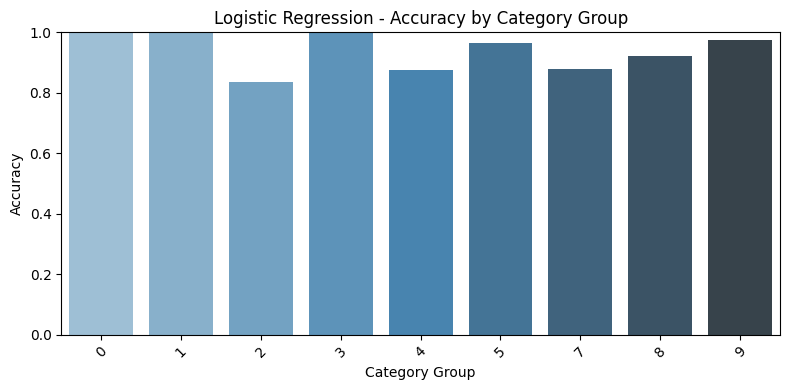

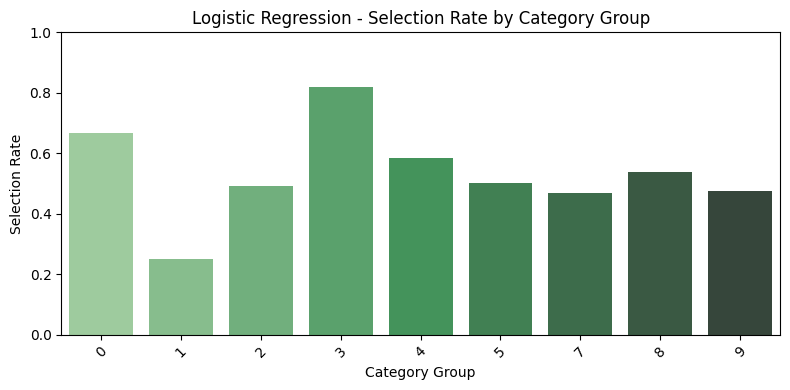

Bar plots saved for Logistic Regression in 'fairness_report_figures/' folder.

Model: Decision Tree
Overall Accuracy: 0.996
Demographic Parity Difference: 0.568
Equalized Odds Difference: 0.029



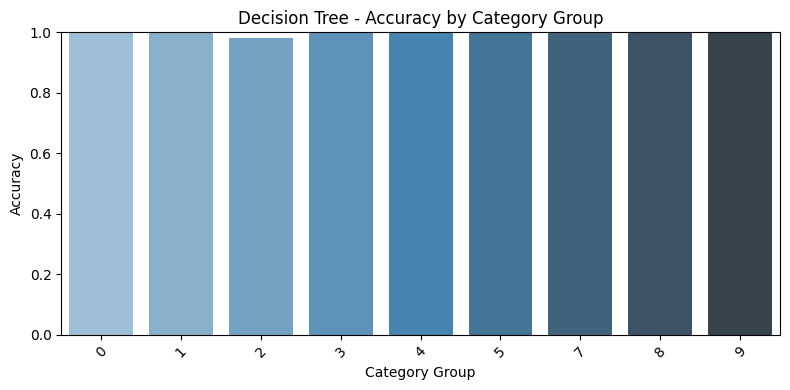

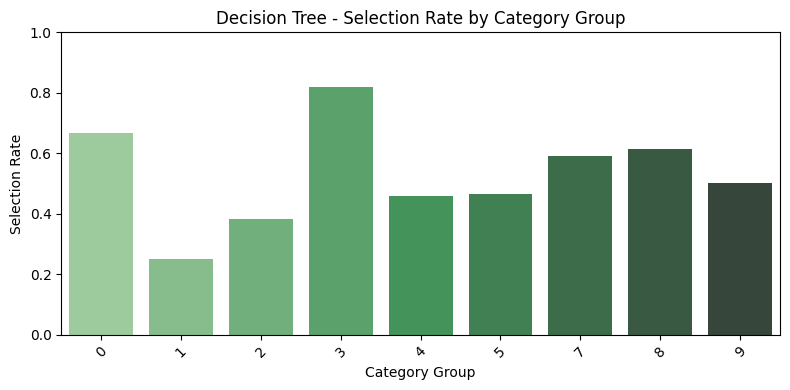

Bar plots saved for Decision Tree in 'fairness_report_figures/' folder.

Model: Random Forest
Overall Accuracy: 0.996
Demographic Parity Difference: 0.568
Equalized Odds Difference: 0.029



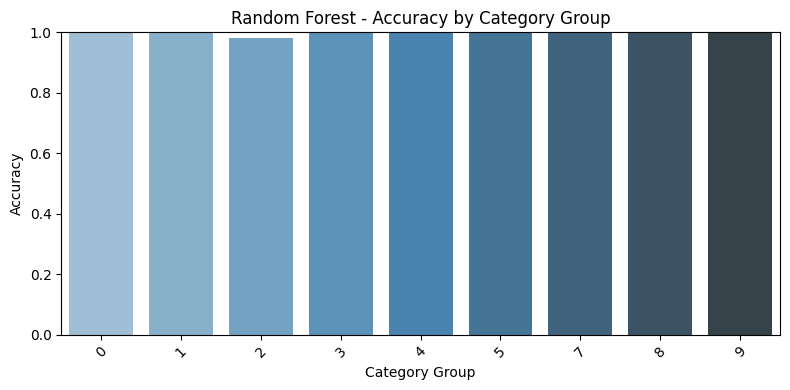

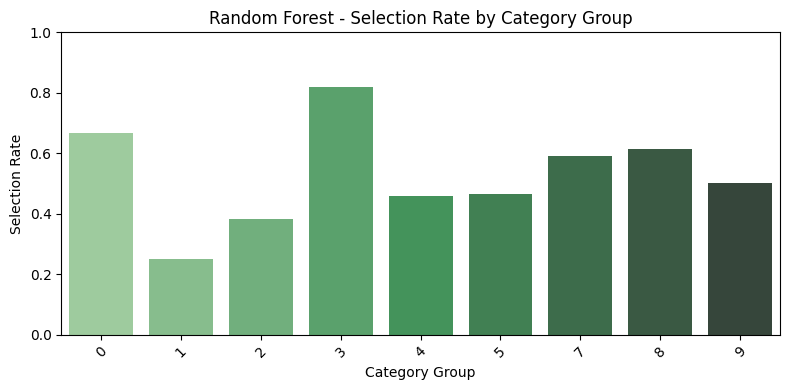

Bar plots saved for Random Forest in 'fairness_report_figures/' folder.


In [ ]:
# -----------------------------------
# 10. Fairness Audit Report with Metrics & Visualizations
# -----------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Create a directory to save figures (optional)
import os
os.makedirs("fairness_report_figures", exist_ok=True)

# Loop through models and generate visualizations
for model_name, res in results.items():
    print("\n====================================")
    print(f"Model: {model_name}")
    print("====================================")

    # Print fairness metrics
    print(f"Overall Accuracy: {res['Overall Accuracy']:.3f}")
    print(f"Demographic Parity Difference: {res['Demographic Parity Difference']:.3f}")
    print(f"Equalized Odds Difference: {res['Equalized Odds Difference']:.3f}\n")

    # Convert Accuracy & Selection Rate by Group to DataFrame for visualization
    acc_df = pd.DataFrame.from_dict(res["Accuracy by Group"], orient='index', columns=['Accuracy'])
    sel_df = pd.DataFrame.from_dict(res["Selection Rate by Group"], orient='index', columns=['Selection Rate'])

    # Bar plot for Accuracy by Group
    plt.figure(figsize=(8,4))
    sns.barplot(x=acc_df.index, y='Accuracy', data=acc_df, palette='Blues_d')
    plt.title(f"{model_name} - Accuracy by Category Group")
    plt.ylabel("Accuracy")
    plt.xlabel("Category Group")
    plt.xticks(rotation=45)
    plt.ylim(0,1)
    plt.tight_layout()
    plt.savefig(f"fairness_report_figures/{model_name}_accuracy_by_group.png")
    plt.show()

    # Bar plot for Selection Rate by Group
    plt.figure(figsize=(8,4))
    sns.barplot(x=sel_df.index, y='Selection Rate', data=sel_df, palette='Greens_d')
    plt.title(f"{model_name} - Selection Rate by Category Group")
    plt.ylabel("Selection Rate")
    plt.xlabel("Category Group")
    plt.xticks(rotation=45)
    plt.ylim(0,1)
    plt.tight_layout()
    plt.savefig(f"fairness_report_figures/{model_name}_selection_rate_by_group.png")
    plt.show()

    print(f"Bar plots saved for {model_name} in 'fairness_report_figures/' folder.")